# Advanced Numerical Analysis

## Exercise 51 - Finite difference method for the Poisson equation

*Given the Poisson equation with Dirichlet boundary conditions,*

$$\begin{cases}
- u_{xx} - u_{yy} = f \quad \textrm{in} \ \Omega = \, ]0, 1[, \\
u = b \quad \textrm{on} \ \partial \Omega
\end{cases}$$

$\textrm{(i)} \quad$ *For* $h = \frac{1}{N+1},$ *use the variables* $u_ {i,k} := u(ih, kh)$ *for* $i, k = 1, \dots, N$ *and the approximation from Exercise 50 to formulate a sparse linear system with integral matrix coefficients that approximately solves the problem with a residual of* $O(h^2)$ *in the original equations. Display the matrix for* $N = 3$ *in a row- or columnwise ordering of the variables.*

Let $\Delta_h^x u(x,y) := u(x+h, y) - 2 u(x,y) + u(x-h, y)$ and $\Delta_h^y u(x,y) := u(x, y+h) - 2 u(x,y) + u(x, y-h).$ Then we can approximate $-\frac{\Delta_h^x u(x,y)}{h^2} - \frac{\Delta_h^y u(x,y)}{h^2} \approx - u_{xx} - u_{yy} = f$ and thus on the grid we can solve

$$-\frac{1}{h^2} \big(u_{i+1,k} + u_{i,k+1} - 4 u_{i,k} + u_{i-1,k} + u_{i,k-1} \big) = f_{i,k} := f(ih, kh) \quad \forall i,k = 2, \dots, N-1.$$

For $i=1$ we compensate for the boundary condition:

$$-\frac{1}{h^2} \big(u_{2,k} + u_{1,k+1} - 4 u_{1,k} + u_{1,k-1} \big) = f_{1,k} + \frac{u_{0,k}}{h^2} = f_{1,k} + \frac{b(0,kh)}{h^2} \quad \forall k = 2, \dots, N-1.$$

Analogously for $i=N$ and $k=0,N$. At the corners, when both indices take an extremal value we similarly add both terms to the right hand side.

If we now write the resulting right hand side as a vector $F \in \mathbb{R}^{N^2}$ in column-wise ordering we can solve the linear system $L U = F$ for $U \in \mathbb{R}^{N^2},$ which is the solution on the inner grid in column-wise ordering. The system matrix is

$$ L = - \frac{1}{h^2} \begin{pmatrix}
T & I      &        &   \\
I & T      & \ddots &   \\
  & \ddots & \ddots & I \\
  &        & I      & T
\end{pmatrix}$$

with unit matrix $I \in \mathbb{R}^N$ and
$$ T = \begin{pmatrix}
-4 & 1      &        &   \\
1  & -4     & \ddots &   \\
   & \ddots & \ddots & 1 \\
   &        & 1      & -4
\end{pmatrix}.$$

$$ $$
$\textrm{(ii)} \quad$ *Write a program for creating and solving the resulting linear system when* $f$ *and* $b$ *are given as functions.*

In [60]:
function u = solve_Poisson(f, b, interval, N)
    
    h = (interval(2) - interval(1)) / (N + 1);
    factor = 1 / h^2;
    steps = linspace(interval(1), interval(2), N+2);
    
    # sample f on inner grid
    X = meshgrid(steps(2:end-1), steps(2:end-1));
    F = f(X, X');
    
    # sample b on boundary
    b_bottom = b(steps, interval(1));
    b_top = b(steps, interval(2));
    b_left = b(interval(1), steps)';
    b_right = b(interval(2), steps)';
    
    # compensate for boundary conditions
    F(1, :) += b_bottom(2:end-1) * factor;
    F(end, :) += b_top(2:end-1) * factor;
    F(:, 1) += b_left(2:end-1) * factor;
    F(:, end) += b_right(2:end-1) * factor;
    
    # column-wise vectorization
    F = vec(F);
    
    # system matrix generation
    M = N^2;
    L = -4 * speye(M);
    L = spdiags(repmat([ones(N-1,1); 0], N, 1), -1, L);
    L = spdiags(repmat([0; ones(N-1,1)], N, 1), 1, L);
    L = spdiags(ones(M,2), [-N N], L);
    L = -factor * L;
        
    # solve and reshape solution
    u = zeros(N+2, N+2);
    u(2:end-1, 2:end-1) = reshape(L \ F, N, N);
    
    # add boundary values
    u(1, :) = b_bottom;
    u(end, :) = b_top;
    u(:, 1) = b_left;
    u(:, end) = b_right;
    
endfunction

$$ $$
$\textrm{(iii)} \quad$ *Choose* $f$ *and* $b$ *such that* $\hat{u}(x, y) := (1 - xy)^4$ *is a solution. Plot the runtime* $t_N$ *and the maximal error* $e_N := \max_{i,k} |u_{i,k} - \hat{u}(ih, kh)|$ *of the computed solution* $u$ *on the grid, for* $N = 5, 10, 20, 50, 100, 200, 500, 1000, 2000.$

In [56]:
Ns = [5, 10, 20, 50, 100, 200, 500, 1000, 2000];
interval = [0, 1];
exact = @(x, y) (1 - x.*y).^4;

# f := -u_xx - u_yy
f = @(x, y) -12 * (1 - x.*y).^2 .* (x.^2 + y.^2);
b = exact;

times = [];
errors = [];
for N = Ns

    # exact values on grid
    steps = linspace(interval(1), interval(2), N+2);
    X = meshgrid(steps, steps);
    exact_vals = exact(X, X');
    
    # runtime measurement of computed solutions
    tic();
    u = solve_Poisson(f, b, interval, N);
    tN = toc();
    times = [times, tN];
    
    # maximal errors
    eN = max(max(abs(u - exact_vals)));
    errors = [errors, eN];
    
endfor

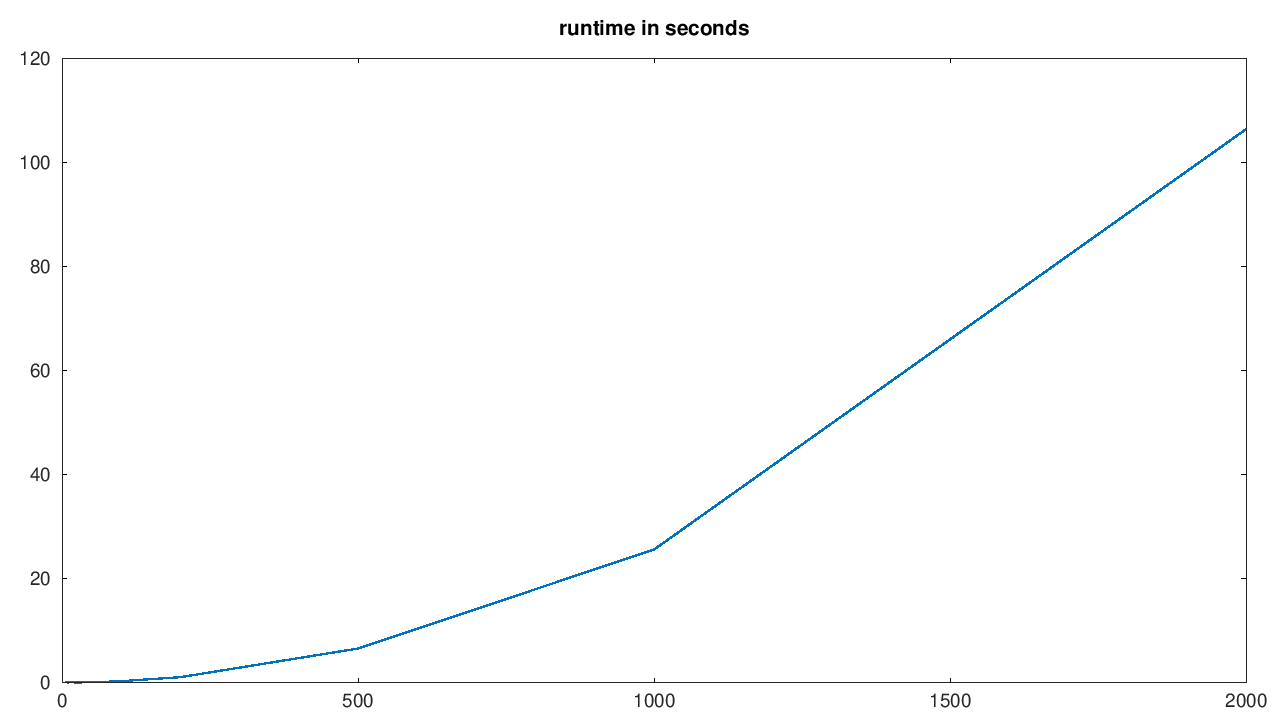

In [57]:
%plot -s 1280,720

plot(Ns, times, "linewidth", 5);
title("runtime in seconds");

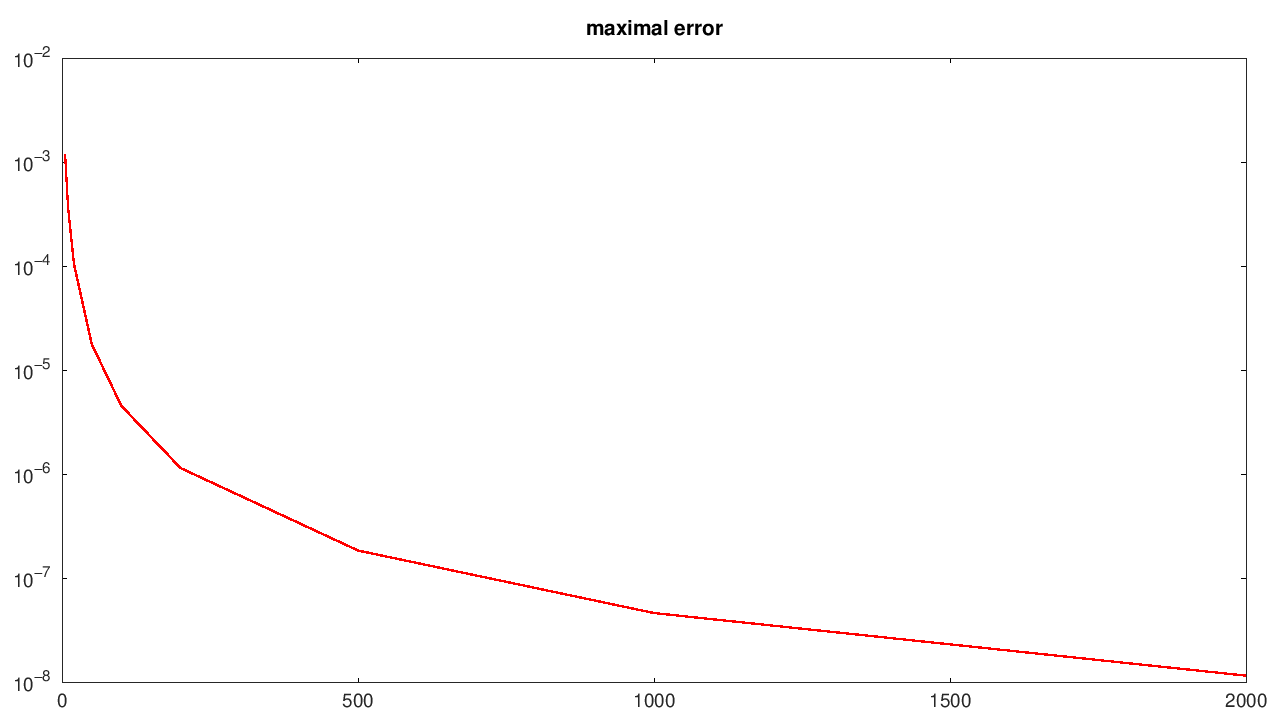

In [58]:
semilogy(Ns, errors, "linewidth", 5, "color", "red");
title("maximal error");

$$ $$
$\textrm{(iv)} \quad$ *Estimate asymptotic power laws* $t_N \approx \alpha N^d$ *and* $e_N \approx \beta N^e$ *by guessing simple numbers for the exponents and checking with a* `loglog` *plot that the quotients approximately approach a constant for large* $N.$

alpha = 1.7209e-05
d = 2.0573
beta = 0.045866
e = -1.9983


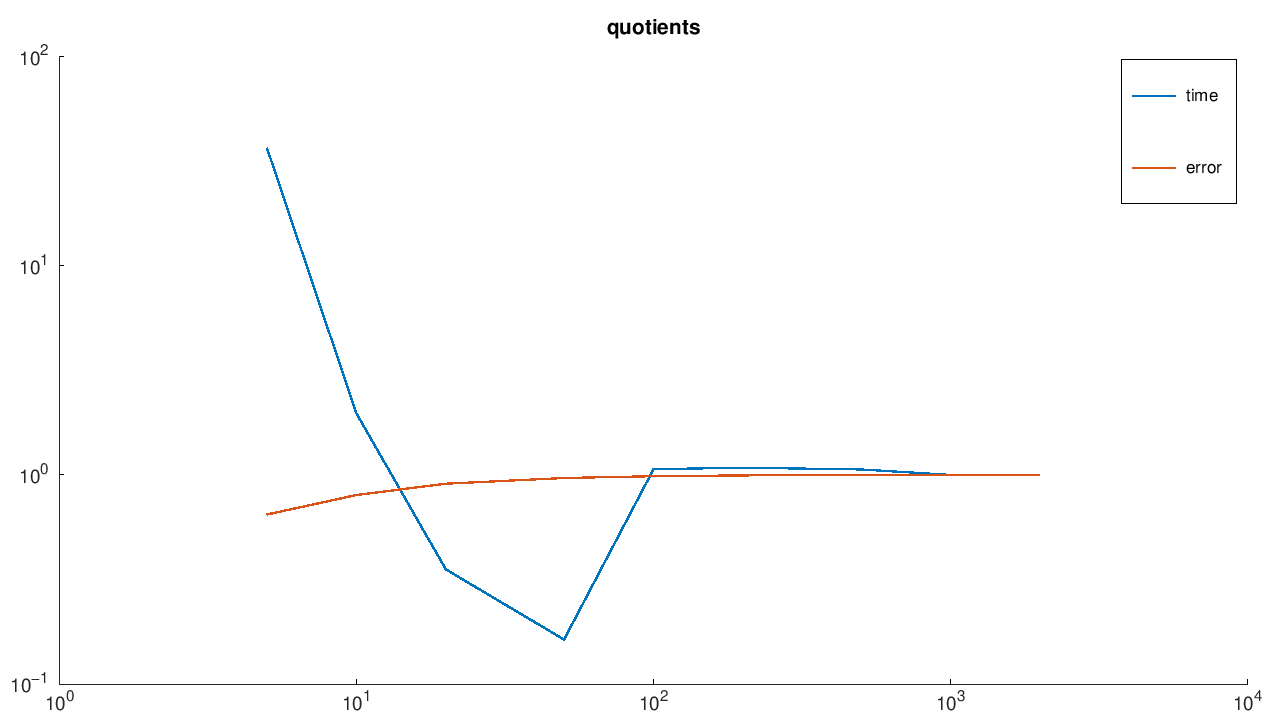

In [59]:
# last elements as variables for convenience
N1 = Ns(end-1);
N2 = Ns(end);
t1 = times(end-1);
t2 = times(end);
e1 = errors(end-1);
e2 = errors(end);

# approximate constants of power law for runtimes
alpha = exp((log(t1) * log(N2) - log(t2) * log(N1)) / (log(N2) - log(N1)))
d = (log(t2) - log(alpha)) / log(N2)
time_quotients = times ./ (alpha * Ns.^d);

# approximate constants of power law of errors
beta = exp((log(e1) * log(N2) - log(e2) * log(N1)) / (log(N2) - log(N1)))
e = (log(e2) - log(beta)) / log(N2)
error_quotients = errors ./ (beta * Ns.^e);

# log plots approach 1
hold on;
loglog(Ns, time_quotients, "linewidth", 5);
loglog(Ns, error_quotients, "linewidth", 5);
title("quotients")
legend("time", "error");